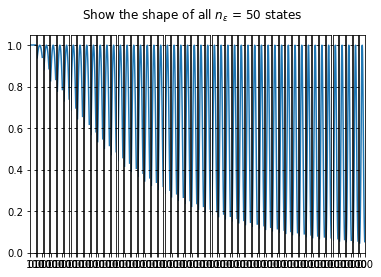

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import math
from sklearn.decomposition import PCA
import plotly.express as px
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from latent import latent
from redatuming import redatuming
from plot_redatuming import plot_redatuming
def g(n,x):
    if n==0:
        return math.e**(-5*(x-0.5)**2)
    elif n==1:
        return math.e**(-10*(x-0.5)**2)
    elif n==2:
        if x<0.3:
            return 3*x
        elif x<0.6:
            return 3*(0.6-x)
        else:
            return 0
    elif n==3:
        return int(x<0.5)
    elif n==4:
        return math.e**(-30*(x-0.5)**2)
    elif n==5:
        return math.cos(2*math.pi*x)
    elif n==6:
        return math.e**(-9*x**2)
    else:
        return np.inf
def g(n,x):
    return math.e**(-n/4*(x-0.5)**2)
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True)
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=0)
pca_cb = PCA(n_components=2)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=0)
MRA_training.generate_default()
MRA_pca.generate_default()
X = MRA_training.X
clear_output()
N_shifts = MRA_pca.shifts.reshape(-1,1)
N_states = np.repeat(MRA_pca.states,nt)
img_list=[]
clear_output()
fig.show()

In [2]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
        if epoch % 10 == 0:
            clear_output(wait = True)
            _,Ns = latent(model,MRA_pca)
            N_reshaped = Ns.reshape(-1,q)
            pca_N = pca_cb.fit_transform(N_reshaped)
            df = pd.DataFrame(pca_N, columns = ['1st','2nd'])
            df_states = pd.DataFrame(N_states,columns=['state']).astype('object') 
            df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
            df = pd.concat([df,df_states,df_shifts],axis=1)
            fig = px.scatter(df, x='1st', y='2nd', color='state', text='shift', title='q=%d,loss=%f'%(q,logs["loss"]))
            fig.update_layout(height=500, margin=dict(l=0, r=0, t=60, b=0))
            #img_list.append(fig)
            fig.show()

In [9]:
model = SymAE(N,nt,d,p,q,kernel_size,filters,dropout_rate)
#model.load_weights('./checkpoint/'+'p=3,q=3')
#model.load_weights('./checkpoint/'+'p=3,q=10,ber,ne=3')
#model.load_weights('./checkpoint/'+'p=3,q=15,add,nor=1')
clear_output()

In [10]:
model.latentcat.drop.stddev = 0.0
model.latentcat.drop.rate = 0.5

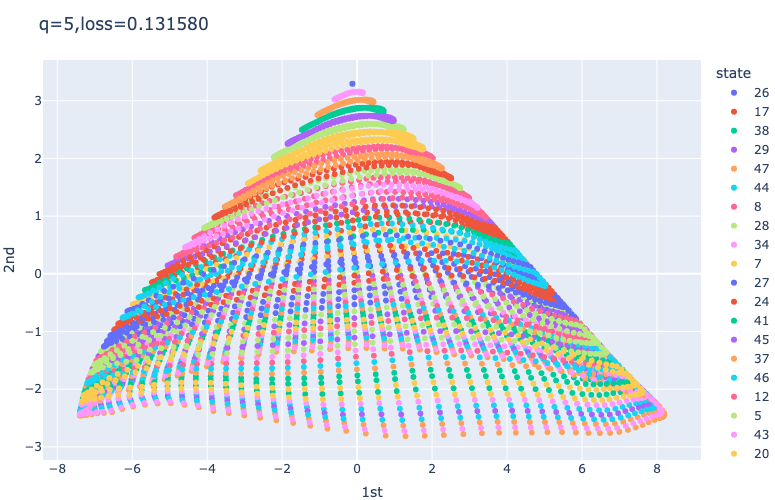

For epoch 1161, loss is 0.098422.
For epoch 1162, loss is 0.084417.
For epoch 1163, loss is 0.091433.


KeyboardInterrupt: 

In [13]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
SGD = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.0,nesterov=False)
model.compile(loss='mse',optimizer=Adam)
history = model.fit(X,X,epochs=100000,verbose=0,callbacks=[CustomCallback()])

In [14]:
model.save_weights('./checkpoint/'+'p=30,q=5,ber,30')

In [ ]:
def find(state,nuisance):
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(100):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j
MRA1, t1 = find(0,3)
MRA2, t2 = find(1,3)
redatum = redatuming(model,MRA1,MRA2,t1,t2)
clear_output()
fig = plot_redatuming(redatum)

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:,0]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]
state_source = 0
nuisance_source = 1
fig, axs = plt.subplots(1, d, sharex=True, sharey=True, figsize=(4*d,4), dpi=40)
for i in range(d):
    coherent_code = enc(state_source, 0)[0: p]
    nuisance_code = enc(nuisance_source, i)[p: p+q]
    latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
    axs[i].plot(range(d), dec(latent_code))
    axs[i].set_title('%d'%i)
plt.suptitle('$\hat{X}_{s=%d \mapsto s=%d}$'%(nuisance_source, state_source), fontsize=50)
plt.subplots_adjust(top=0.6)
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

In [ ]:
dim = 2
pca = PCA(n_components=dim)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs,Ns = latent(model,MRA_pca)
N_reshaped = Ns.reshape(-1,q)
N_shifts = MRA_pca.shifts.reshape(-1,1)
pca_N = pca.fit_transform(N_reshaped)
pca_N = N_reshaped[:,1:3]
if dim == 3:
    pca_N = N_reshaped
    df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'][0:dim])
    df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state', text='shift')
if dim ==2:
    df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'][0:dim])
    df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    #df = df[df['state']==0]
    df = df[0:1000]
    fig = px.scatter(df, x='1st', y='2nd', color='state', text='shift')
    fig.update_layout(height=600, margin=dict(l=0, r=0, t=0, b=0))
fig.show()

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:,0]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]
state_source = 0
nuisance_source = 0
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4,4), dpi=200)
a=40
b=0
for i in np.arange(0,11,1):
    alpha = 0.1*i
    coherent_code = enc(state_source, 0)[0: p]
    nuisance_code55 = enc(nuisance_source, a)[p: p+q]
    nuisance_code56 = enc(nuisance_source, b)[p: p+q]
    Cos = sum(nuisance_code56*nuisance_code55)
    angle55 = np.arccos(Cos)*alpha
    angle56 = np.arccos(Cos)*(1-alpha)
    nuisance_code = np.sin(angle55)*nuisance_code55 + np.sin(angle56)*nuisance_code56
    nuisance_code = nuisance_code / np.linalg.norm(nuisance_code)
    latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
    latent_code55 = np.concatenate([coherent_code, nuisance_code55], axis=0)
    latent_code56 = np.concatenate([coherent_code, nuisance_code56], axis=0)
    c=alpha*a+(1-alpha)*b
    axs.plot(range(d), dec(latent_code), color=(alpha,0,1-alpha))
    #axs.plot(range(d), [g(state_source, ((k+c)%d)/d) for k in range(d)], color=(1,0,1))
    #axs[i].plot(range(d), dec(latent_code55), label='output %d'%a)
    #axs[i].plot(range(d), dec(latent_code56), label='output %d'%b)
    #axs.legend()
plt.legend()
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

In [ ]:
import os
import imageio
images = []
for i in trange(len(img_list)):
    fig = img_list[i]
    with open("fig1.png", "wb") as f:
        f.write(scope.transform(fig, format="png"))
    images.append(imageio.imread('./fig1.png'))
imageio.mimsave('./movie9.gif', images)